In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import os

## Load data

In [2]:
path_to_data = '/home/dafne/shared/FilterBubble/topic-modeling/'
# fname = os.path.join(path_to_data, 'texts_rens.csv')

# data = pd.read_csv(fname)
data = pd.read_csv(os.path.join(path_to_data, 'Felicia-Archive', 'preprocessed.csv'))

In [3]:
data.head()

,ID,topic,date,text,text_prep,topic_name,sample
0,#100 @328419 +2073,99,1/16/1999,De andere wereld van zondagmorgen. Antropoloog...,wereld zondagmorg antropolog dr mattijs port d...,Other issue,test
1,#10000 @16311398 +11159,16,12/6/2008,"SAMENVATTINGDE SPEURTOCHT VAN EFRAIM ZUROFF, n...",samenvattingd speurtocht efraim zuroff nazijag...,Defense,test
2,#10004 @16327565 +1346,16,12/5/2008,Vol verwachting kloppen de hartjes van onze st...,vol verwacht klopp hartjes onz stoer mann oero...,Defense,train
3,#10004 @34719038 +2546,5,5/1/2001,Wie als nieuwkomer bij een bedrijf denkt dat h...,nieuwkomer bedrijf denkt flink salaris gestege...,Labor and employment,train
4,#10005 @37431676 +6256,3,5/7/2001,In ziekenhuizen in Hengelo en Leeuwarden wordt...,ziekenhuiz hengelo leeuward vandag gestaaktw w...,Health,train


## Explore topics

In [4]:
# # What are the topic_six categories?
# for topic in sorted(data.topic_six.unique()):
#     print(topic)
#     print(data[data.topic_six==topic].topic_name.value_counts())

In [5]:
# Check headlines of topics
for topic in data.topic_name.value_counts().index:
    print(topic)
    print(data[data.topic_name==topic].text[:30].values)
    print('\n')

Government operations
["Het politieke leven van staatssecretaris H. van Hoof (VVD) heeft aan een zijdendraadje gehangen. De bewindsman van Defensie was dinsdag, op de eerste dag vanhet debat over de vuurwerkramp in Enschede, al bereid zijn ontslag in te dienenbij koningin Beatrix.Het eerste optreden van Van Van Hoof deed de andere ministers vrezen dat hij zousneuvelen. Daarom hebben ze hem geen tweede keer meer aan het woord laten komen.Dit bevestigen goed ingelichte bronnen.In het weekeinde voorafgaande aan het debat wordt het de ex-marineman Van Hoofduidelijk dat een aantal PvdA-Kamerleden uit is op zijn hoofd, in het bijzonderwoordvoerster M. Wagenaar.Van Hoof raakt dinsdag in de namiddag aangeslagen als Wagenaar politiek geladenwoorden in zijn richting uitspreekt. Zij houdt hem verantwoordelijk voor het'ontbreken van militaire precisie' op het bureau adviseur Milieuvergunningen. DePvdA'ster omarmt de conclusie van de commissie-Oosting dat er mogelijk geen 22doden waren gevallen als

["In ziekenhuizen in Hengelo en Leeuwarden wordt vandaag gestaakt.'We willen het hart van het ziekenhuis treffen.'De wasmachines op de sterilisatie-afdeling van het StreekziekenhuisMidden-Twente in Hengelo draaien niet. De 'netten' met klemmen, scharen enpincetten worden slechts in noodgevallen gereinigd. Normaal gesproken zijn ervijftien personen aan het werk. Vandaag draaien zes assistenten eenzondagsdienst. Met een haarnet over het hoofd, armen over elkaar en groeneoperatiekleding aan, wachten ze op de dingen die komen. Ze kunnen moeilijkwennen aan de rust. 'Bij anderen is het vaak hollen of stilstaan. Bij ons is hetaltijd hollen.'Het is een strategische keuze van de vakbonden om de sterilisatie-afdeling alseerste stil te leggen. Daardoor draaien nu ook andere afdelingen op halvekracht. In Hengelo zijn vier van de zes operatiekamers gesloten en is het op dedagverpleging opmerkelijk rustig. Afgelopen week zijn zestig patienten gebeldmet de mededeling dat hun operatie vandaag niet doo


Weather and natural disasters
["Dikke, donkere rookpluimen stijgen op van het Italiaanse eiland Sicilie, waar devulkaan Etna sinds zondag grote hoeveelheden lava en as uitstoot. Hetvulkaangeweld ging gisteren gepaard met een aardbeving van 4,4 op de schaal vanRichter. De schok leidde tot grote paniek in het dorp Santa Venerina, tenzuidoosten van de Etna. Honderden huizen, winkels en de plaatselijke kerkraakten beschadigd. Meer dan duizend mensen zijn dakloos geworden, maarpersoonlijke ongelukken hebben zich nog niet voorgedaan. Hoteleigenaars isgevraagd bedden voor de getroffenen beschikbaar te stellen. De lavastromenvormen volgens deskundigen geen direct gevaar voor de omringende dorpen.Niettemin riep de Italiaanse regering gisteravond de noodtoestand uit in deomgeving van de vulkaan. Zij riep de omwonenden op zoveel mogelijk binnen teblijven vanwege asregens. Vulkanologen zeggen dat de Etna door de nieuweuitbarsting een meter in de richting van de zee is opgeschoven. Opsatellietfoto



Community development and housing
["Het aantal Nederlanders per woning daalt gestaag. Huishoudens 'verdunnen',nieuwe huizen worden groter, oude worden samengevoegd.De gemiddelde Nederlander woont groter dan ooit. Terwijl het gevoel steedsalgemener wordt dat Nederland vol raakt of zelfs al vol is, krijgt deNederlander steeds meer woonruimte tot zijn beschikking, zo blijkt uit cijfersvan het ministerie van Volkshuivesting en het Centraal Bureau voor deStatistiek.Had de gemiddelde nieuwbouwwoning in 1985 nog een inhoud van 335 kubieke meter,in 1999 was dit opgelopen tot 484 kubieke meter. Voor oudere woningen zijndergelijke cijfers niet voorhanden. Maar ook deze zijn zeker groter geworden,doordat bij vernieuwing van oude woningblokken drie appartementen werdensamengevoegd tot twee appartementen of twee woningen tot een.De 'huishoudenverdunning' blijkt onstuitbaar. Door de groei van bijvoorbeeld hetaantal alleenstaanden, een verschijnsel waar de Gezinsraad vorige week nog opwees, wonen g

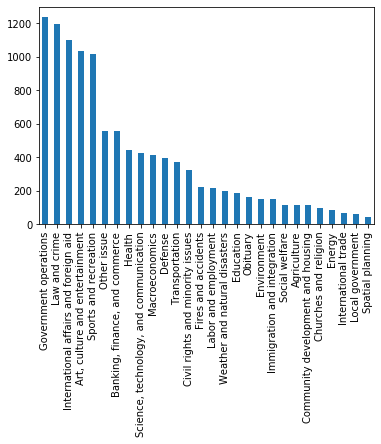

In [6]:
data.topic_name.value_counts().plot(kind='bar')

In [7]:
data.groupby(['topic', 'topic_name']).count()['ID']

topic  topic_name                            
1      Macroeconomics                             412
2      Civil rights and minority issues           322
3      Health                                     444
4      Agriculture                                114
5      Labor and employment                       217
6      Education                                  186
7      Environment                                150
8      Energy                                      81
9      Immigration and integration                149
10     Transportation                             371
12     Law and crime                             1197
13     Social welfare                             115
14     Community development and housing          114
15     Banking, finance, and commerce             556
16     Defense                                    393
17     Science, technology, and communication     426
18     International trade                         66
19     International affairs and for

## Data cleaning / selection

In [8]:
topic_nonpol = [444, 23, 29, 30, 31, 99]
data['topic_binary'] = [0 if t in topic_nonpol else 1 for t in data['topic']]

In [9]:
#data_sub = data[data.code.isin(topic_sub)].dropna(subset=['text'])
#data_sub = data.dropna(subset=['text', 'topic_six']).sample(5000)
data_train = data[data['sample']=='train'] #data.sample(4000)

## Classification pipeline

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn import metrics

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(data_train.text_prep.values, 
                                                  data_train.topic_binary, 
                                                  test_size=0.33, 
                                                  random_state=0, 
                                                  stratify=data_train.topic_binary)

In [14]:
from sklearn.pipeline import Pipeline
text_clf = Pipeline([
     ('vect', CountVectorizer(min_df=5, max_df=0.9)),
     ('tfidf', TfidfTransformer()),
     ('clf', PassiveAggressiveClassifier())
])

In [15]:
text_clf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=0.9,
                                 max_features=None, min_df=5,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=Non...
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 PassiveAggressiveClassifier(C=1.0, average=False,
                                             class_weight=None,
                                             earl

In [16]:
predicted = text_clf.predict(X_val)

In [29]:
target_names = ['non-political', 'political']#[topic_names[i] for i in sorted(topic_sub)]

In [30]:
print(metrics.classification_report(y_val, predicted, target_names=target_names))

               precision    recall  f1-score   support

non-political       0.78      0.74      0.76       756
    political       0.91      0.92      0.92      2157

     accuracy                           0.88      2913
    macro avg       0.84      0.83      0.84      2913
 weighted avg       0.88      0.88      0.88      2913



In [53]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
parameters = {
     'vect__ngram_range': [(1, 1), (1, 2)],
     'vect__min_df': [2, 5],
    'vect__max_df': [0.9, 0.95],
     #'tfidf__use_idf': (True, False),
     'clf__class_weight': ('balanced', None),
}

In [54]:
gs_clf = RandomizedSearchCV( #GridSearchCV(
    text_clf, parameters, cv=5, iid=False, n_jobs=-1, 
                      scoring=['f1','precision', 'recall'],refit='f1')

In [55]:
data_train_sub = data_train.sample(1000)
gs_clf = gs_clf.fit(data_train_sub.text_prep, data_train_sub.topic_binary)

In [56]:
results_cv = pd.DataFrame(gs_clf.cv_results_)
results_cv.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_vect__ngram_range', 'param_vect__min_df', 'param_vect__max_df',
       'param_clf__class_weight', 'params', 'split0_test_f1', 'split1_test_f1',
       'split2_test_f1', 'split3_test_f1', 'split4_test_f1', 'mean_test_f1',
       'std_test_f1', 'rank_test_f1', 'split0_test_precision',
       'split1_test_precision', 'split2_test_precision',
       'split3_test_precision', 'split4_test_precision', 'mean_test_precision',
       'std_test_precision', 'rank_test_precision', 'split0_test_recall',
       'split1_test_recall', 'split2_test_recall', 'split3_test_recall',
       'split4_test_recall', 'mean_test_recall', 'std_test_recall',
       'rank_test_recall'],
      dtype='object')

In [57]:
param_columns = [c for c in results_cv.columns if c.startswith('param_')]
results_cv.sort_values('mean_test_f1')[param_columns + 
                                       ['mean_test_f1', 'mean_test_precision', 'mean_test_recall']]

,param_vect__ngram_range,param_vect__min_df,param_vect__max_df,param_clf__class_weight,mean_test_f1,mean_test_precision,mean_test_recall
6,"(1, 1)",5,0.95,None,0.897462,0.865612,0.932071
4,"(1, 1)",5,0.9,None,0.897914,0.867434,0.930755
0,"(1, 1)",5,0.9,balanced,0.898444,0.863890,0.936088
8,"(1, 2)",5,0.95,balanced,0.899288,0.863308,0.938728
7,"(1, 2)",5,0.9,balanced,0.901998,0.869175,0.937422
3,"(1, 1)",2,0.95,None,0.913844,0.877559,0.953386
9,"(1, 1)",2,0.9,None,0.914982,0.873985,0.960044
5,"(1, 1)",2,0.9,balanced,0.915025,0.879666,0.953395
2,"(1, 2)",2,0.9,None,0.915314,0.871339,0.964053
1,"(1, 2)",2,0.9,balanced,0.916023,0.877054,0.958711


## Apply on test set

In [58]:
data_test = data[data['sample']=='test']

In [59]:
# Train on complete train data set
clf = gs_clf.best_estimator_ 
clf.fit(data_train['text_prep'], data_train['topic_binary'])

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=0.9,
                                 max_features=None, min_df=2,
                                 ngram_range=(1, 2), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=Non...
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 PassiveAggressiveClassifier(C=1.0, average=False,
                                             class_weight='balanced',
                                           

In [60]:
predicted = clf.predict(data_test['text_prep'])

In [61]:
print(metrics.classification_report(data_test['topic_binary'], predicted, target_names=target_names))

               precision    recall  f1-score   support

non-political       0.84      0.74      0.79       572
    political       0.91      0.95      0.93      1635

     accuracy                           0.90      2207
    macro avg       0.88      0.85      0.86      2207
 weighted avg       0.89      0.90      0.89      2207



In [62]:
pd.DataFrame(metrics.confusion_matrix(data_test['topic_binary'], predicted), 
             index=target_names, columns=target_names)

,non-political,political
non-political,423,149
political,80,1555
